In [1]:
import sys
sys.path.append('../src/')
import importlib
from matplotlib import pylab as plt
%matplotlib inline 

import numpy as np
import torch
import torchvision

import cifar_data
import resnet18
import module2graph
import utils
import dartslike
importlib.reload(utils)
importlib.reload(module2graph)
importlib.reload(dartslike)


<module 'dartslike' from '../src/dartslike.py'>

In [2]:
class LowRankLinear(torch.nn.Module):
    def __init__(self, in_, out_, dim=1):
        super().__init__()
        self.l = torch.nn.Parameter(torch.randn(in_, dim)*1e-3)
        self.r = torch.nn.Parameter(torch.randn(dim, out_) * 1e-3)
    
    def forward(self, x):
        #print (x.shape, self.l.shape, self.r.shape)
        return x@self.l@self.r
    

In [3]:
batch_size = 64
device = 'cpu'
trial_num = 1
epoch_num = 1
lr = 1e-3
batch_seen = 5

In [4]:
trainloader, valloader, testloader = cifar_data.get_dataloaders([8,9], batch_size=batch_size, need_val=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = resnet18.ResNet18(8).to(device)
model.load_state_dict(torch.load('../data/model_last.ckpt', map_location=device))
model.model.fc = torch.nn.Linear(512, 2)
model = module2graph.GraphInterperterWithBernGamma(model, 1.0)

Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
layer_names = list(model.forward(torch.randn(64, 3, 33, 33), intermediate=True)[1].keys())
sizes = {}
for k,v in model(torch.randn(64, 3, 33, 33), intermediate=True)[1].items():
    sizes[k] = v.shape
layer_names = [k for k in layer_names if k not in ['flatten', 'x']]
layer_names = ['model_fc']

In [7]:
class Aux(torch.nn.Module):
    def __init__(self, sizes, layer_names):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layer_names = layer_names
        self.means_int = {}
        self.lsigmas_int = {}
        self.means_y = {}
        self.lsigmas_y = {}
        
        for i in range(len(layer_names)-1):
            current = layer_names[i]
            next_ = layer_names[i+1]
            mat_size = np.prod(sizes[current][1:]) * np.prod(sizes[next_][1:])
            if mat_size>1024*1024:
                linear = LowRankLinear(np.prod(sizes[current][1:]), np.prod(sizes[next_][1:]))
            else:
                linear = torch.nn.Linear(np.prod(sizes[current][1:]), np.prod(sizes[next_][1:]))
            
            lsigma = torch.nn.Parameter(torch.tensor(-2.0))
            self.means_int[current] = linear
            self.lsigmas_int[current] = lsigma
            self.layers.append(linear)
            
        for i in range(len(layer_names)):
            current = layer_names[i]
            linear = torch.nn.Linear(np.prod(sizes[current][1:]), 2)
            lsigma = torch.nn.Parameter(torch.tensor(-2.0))
            self.means_y[current] = linear
            self.lsigmas_y[current] = lsigma
            self.layers.append(linear)
            


        
                                        

In [8]:
for parameter_opt_type in ['MI', 'CE']:
    for gamma_opt_type in ['MI', 'CE']:
        for lam in [0.0, 0.25, 0.5, 0.75, 1.0][::-1]:
            print (parameter_opt_type, gamma_opt_type, lam)

MI MI 1.0
MI MI 0.75
MI MI 0.5
MI MI 0.25
MI MI 0.0
MI CE 1.0
MI CE 0.75
MI CE 0.5
MI CE 0.25
MI CE 0.0
CE MI 1.0
CE MI 0.75
CE MI 0.5
CE MI 0.25
CE MI 0.0
CE CE 1.0
CE CE 0.75
CE CE 0.5
CE CE 0.25
CE CE 0.0


In [9]:
!ls -lh --sort=time

total 504K
-rw-rw-r-- 1 legin legin 229K дек 25 17:59 dartslike_mi.ipynb
-rw-rw-r-- 1 legin legin  664 дек 25 17:58 MI.MI.0.5.pckl
-rw-rw-r-- 1 legin legin  662 дек 25 17:55 MI.MI.0.75.pckl
-rw-rw-r-- 1 legin legin  664 дек 25 17:52 MI.MI.1.0.pckl
-rw-rw-r-- 1 legin legin  40K дек 25 17:50 dartslike.ipynb
-rw-rw-r-- 1 legin legin 126K дек  6 00:21 random_prune.ipynb
-rw-rw-r-- 1 legin legin  74K дек  5 23:48 full_model_from_scratch.ipynb
-rw-rw-r-- 1 legin legin 8,5K ноя 20 19:18 out
drwxrwxr-x 3 legin legin 4,0K ноя 20 18:26 data


MI.MI.1.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5734999775886536


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.843500018119812


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8740000128746033


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8554999828338623


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.7950000166893005


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8224999904632568


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8765000104904175


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8755000233650208


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.9014999866485596


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8974999785423279


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.9035000205039978


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8755000233650208


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.MI.1.0 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.75


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.503000020980835


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.7490000128746033


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.7825000286102295


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.843500018119812


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8815000057220459


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8730000257492065


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8504999876022339


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8654999732971191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8464999794960022


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8774999976158142


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8774999976158142


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.859000027179718


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.MI.0.75 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.5


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.6039999723434448


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.8475000262260437


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8560000061988831


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8675000071525574


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8709999918937683


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8504999876022339


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8345000147819519


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8309999704360962


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8600000143051147


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.871999979019165


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8794999718666077


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8700000047683716


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.MI.0.5 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.25


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5210000276565552


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.7009999752044678


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.7459999918937683


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8134999871253967


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8314999938011169


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8165000081062317


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8479999899864197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.843999981880188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.859000027179718


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8479999899864197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8355000019073486


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.7745000123977661


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.MI.0.25 (tensor(0.8833), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.MI.0.0 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.1.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.6384999752044678


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.8525000214576721


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.8575000166893005


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.878000020980835


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8725000023841858


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8414999842643738


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8464999794960022


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8364999890327454


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.887499988079071


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8374999761581421


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8119999766349792


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.7900000214576721


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8015000224113464


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8504999876022339


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.CE.1.0 (tensor(0.8000), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.75


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.6614999771118164


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.8119999766349792


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.8345000147819519


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8125


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8805000185966492


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8849999904632568


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8995000123977661


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.9010000228881836


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.7369999885559082


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8619999885559082


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.9039999842643738


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8955000042915344


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8914999961853027


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.CE.0.75 (tensor(0.8000), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.5


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5130000114440918


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.6980000138282776


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.8059999942779541


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8475000262260437


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8765000104904175


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.859000027179718


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8565000295639038


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8870000243186951


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8370000123977661


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8295000195503235


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8989999890327454


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8884999752044678


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8834999799728394


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.CE.0.5 (tensor(0.8833), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.25


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5569999814033508


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.8324999809265137


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.8690000176429749


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.890999972820282


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8884999752044678


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8794999718666077


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8640000224113464


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8730000257492065


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8525000214576721


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8080000281333923


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.7795000076293945


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.7979999780654907


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.887499988079071


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.CE.0.25 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5024999976158142


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.4880000054836273


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5130000114440918


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5099999904632568


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.512499988079071


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5115000009536743


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5170000195503235


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.512499988079071


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5184999704360962


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5139999985694885


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5174999833106995


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5210000276565552


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5189999938011169


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5189999938011169


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.CE.0.0 (tensor(0.9333), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.1.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.8450000286102295


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.7754999995231628


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8355000019073486


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.7570000290870667


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5795000195503235


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5490000247955322


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5860000252723694


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8184999823570251


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8665000200271606


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8495000004768372


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8295000195503235


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.7480000257492065


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.1.0 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.0.75


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.6159999966621399


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.8615000247955322


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8694999814033508


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8669999837875366


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8349999785423279


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.7770000100135803


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8370000123977661


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8849999904632568


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8080000281333923


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8414999842643738


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8855000138282776


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8865000009536743


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.75 (tensor(0.9000), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.0.5


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5740000009536743


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.777999997138977


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8029999732971191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8090000152587891


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8399999737739563


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8554999828338623


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8084999918937683


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8040000200271606


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8495000004768372


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.862500011920929


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.7879999876022339


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8075000047683716


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.5 (tensor(0.7667), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.0.25


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5134999752044678


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.718999981880188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.7099999785423279


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.7785000205039978


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8479999899864197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8475000262260437


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.828499972820282


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.7565000057220459


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.7225000262260437


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.7055000066757202


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.840499997138977


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.862500011920929


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.25 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.0.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.6345000267028809


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.843999981880188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8790000081062317


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8374999761581421


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8914999961853027


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8934999704360962


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8765000104904175


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8629999756813049


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8374999761581421


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8585000038146973


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.906499981880188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8870000243186951


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.0 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.CE.0.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5005000233650208


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.7634999752044678


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.8709999918937683


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.7839999794960022


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.7764999866485596


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8619999885559082


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8454999923706055


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8734999895095825


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8560000061988831


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8784999847412109


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8845000267028809


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.7670000195503235


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8884999752044678


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.CE.0.0 (tensor(0.7833), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])


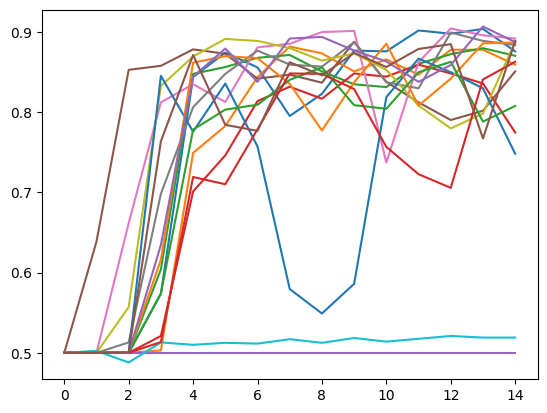

In [9]:
import pickle
import os
import gc
res = {}
for parameter_opt_type in ['MI', 'CE']:
    for gamma_opt_type in ['MI', 'CE']:
        for lam in [0.0, 0.25, 0.5, 0.75, 1.0][::-1]:
            
            if gamma_opt_type == 'CE' and parameter_opt_type == 'CE' and lam != 0.0:
                continue
            name = f'{parameter_opt_type}.{gamma_opt_type}.{lam}'
            print (name)
            if os.path.exists(name+'.pckl'):
                continue
            model = resnet18.ResNet18(8).to(device)
            aux = Aux(sizes, layer_names)
            model.load_state_dict(torch.load('../data/model_last.ckpt', map_location=device))
            model.model.fc = torch.nn.Linear(512, 2)
            model = module2graph.GraphInterperterWithBernGamma(model, 1.0)
            importlib.reload(dartslike)
            dl = dartslike.DartsLikeTrainer(model, parameter_optimization=parameter_opt_type, gamma_optimization=gamma_opt_type,
                                            aux=aux,MI_Y_lambda=lam)
            history = dl.train_loop(trainloader, valloader, testloader, batch_seen, epoch_num, 1e-3, 1e-3, device, 1e-6, )
            
            plt.plot(history, label=lam)
            model.make_gammas_discrete()
            model.discrete = True
            history2 = utils.train_loop(model, trainloader, testloader, batch_seen, epoch_num, lr, device)
            res[name] =  (model.gammas.mean(), history2)
            print (name, res[name])
            with open(name+'.pckl','wb') as out:
                out.write(pickle.dumps( (res[name], history)))
            del model
            del aux
            gc.collect()

MI.MI.1.0 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.75 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.5 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.25 (tensor(0.8833), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.0 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.1.0 (tensor(0.8000), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.75 (tensor(0.8000), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.5 (tensor(0.8833), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.25 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.0 (tensor(0.9333), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

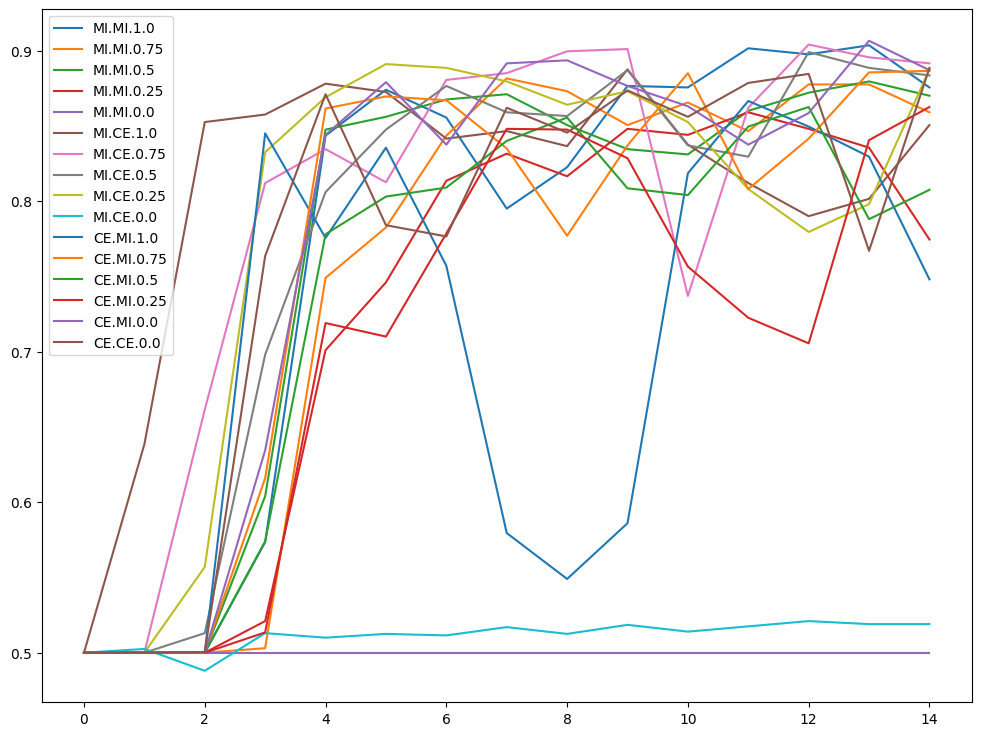

In [10]:
plt.rcParams['figure.figsize'] = (12, 9)
for parameter_opt_type in ['MI', 'CE']:
    for gamma_opt_type in ['MI', 'CE']:
        for lam in [0.0, 0.25, 0.5, 0.75, 1.0][::-1]:
            
            if gamma_opt_type == 'CE' and parameter_opt_type == 'CE' and lam != 0.0:
                continue
            name = f'{parameter_opt_type}.{gamma_opt_type}.{lam}'
            with open(name+'.pckl', 'rb') as inp:
                result, history = pickle.loads(inp.read())
                print (name, result)
                plt.plot(history, label=name)
plt.legend(loc='best')